In [ ]:
# ============================================================
# 0. INSTALLATION (run once per new Colab session)
# ============================================================
!pip install -q bertopic umap-learn hdbscan polars sentence-transformers \
                datasets transformers tensorflow scikit-learn joblib


In [17]:
# ============================================================
# 1. IMPORTS & GLOBAL CONFIG
# ============================================================
import os
import joblib
import numpy as np
import polars as pl

from google.colab import drive
from datasets import load_dataset

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

from transformers import pipeline


In [ ]:
# ============================================================
# 2. MOUNT DRIVE & BASIC PATHS
# ============================================================
DRIVE_PATH = "/content/drive/My Drive/DS_Project/"
os.makedirs(DRIVE_PATH, exist_ok=True)

drive.mount("/content/drive")
print(f"Using DRIVE_PATH = {DRIVE_PATH}")


In [14]:
# ============================================================
# 3. RAW DATA LOADING (Exorde dataset)  [HEAVY STEP]
#    - REBUILD_DATA = False if already have df_full_analyzed
#      saved as a parquet file in Drive.
# ============================================================
REBUILD_DATA = False
N_MAX = 100_001
MIN_TOPIC_SIZE = 50           # BERTopic min_topic_size

if REBUILD_DATA:
    print("▶ Streaming data from HuggingFace (Exorde)...")
    stream = load_dataset(
        "Exorde/exorde-social-media-december-2024-week1",
        split="train",
        streaming=True
    )

    batch = []
    for i, row in enumerate(stream):
        batch.append(row)
        if i + 1 >= N_MAX:
            break

    df_full = pl.DataFrame(batch)
    df_full_en = df_full.filter(pl.col("language") == "en")
    texts_full = df_full_en["original_text"].to_list()
    print(f"Loaded {df_full.shape[0]} rows total; English only: {df_full_en.shape[0]}")
else:
    print("⏭ Skipping raw data streaming (REBUILD_DATA = False)")


⏭ Skipping raw data streaming (REBUILD_DATA = False)


In [ ]:
# ============================================================
# 4. EMBEDDING GENERATION  [HEAVY STEP – RUN ONCE IF REBUILDING]
# ============================================================
print("\nGenerating full 73K embeddings... (Time-consuming step)")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
emb_full = embedder.encode(texts_full, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
np.save(DRIVE_PATH + 'embeddings_full.npy', emb_full)
print(f"Embeddings saved to Drive. Shape: {emb_full.shape}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Mounted at /content/drive
Loading data... (This may take a moment)


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/132 [00:00<?, ?it/s]

Total English posts to analyze: 73834

Generating full 73K embeddings... (Time-consuming step)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1154 [00:00<?, ?it/s]

Embeddings saved to Drive. Shape: (73834, 384)


In [15]:
# ============================================================
# 5. TOPIC MODELING WITH BERTopic  [HEAVY STEP – RUN ONCE IF REBUILDING]
# ============================================================
if REBUILD_DATA:
    print(f"\n▶ Running BERTopic with min_topic_size = {MIN_TOPIC_SIZE}...")

    umap_model = UMAP(
        n_neighbors=7,
        n_components=10,
        min_dist=0.05,
        metric="cosine",
        random_state=42,
    )

    hdbscan_model = HDBSCAN(
        min_cluster_size=20,
        min_samples=1,
        metric="euclidean",
        prediction_data=False,
    )

    emb_full = np.load(os.path.join(DRIVE_PATH, "embeddings_full.npy"))

    topic_model_full = BERTopic(
        language="english",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=MIN_TOPIC_SIZE,
        low_memory=True,
        calculate_probabilities=False,
        verbose=True,
    )

    topics_full, _ = topic_model_full.fit_transform(texts_full, emb_full)
    print("✅ BERTopic clustering complete.")

    # --- Attach topics back to the English-only dataframe ---
    topics_full_np = np.array(topics_full, dtype=np.int64)
    topic_series_full = pl.Series("topic_id", topics_full_np)
    df_full_analyzed = df_full_en.with_columns(topic_series_full)


    # Save artifacts
    joblib.dump(topic_model_full, os.path.join(DRIVE_PATH, "topic_model_full.pkl"))
    df_full_analyzed.write_parquet(os.path.join(DRIVE_PATH, "df_full_analyzed.parquet"))

    info_full = topic_model_full.get_topic_info()
    num_topics_full = (info_full["Topic"] != -1).sum()
    print(f"✅ Final Total Topics (Topic IDs != -1): {num_topics_full}")
else:
    print("⏭ Skipping BERTopic training (REBUILD_DATA = False)")


⏭ Skipping BERTopic training (REBUILD_DATA = False)


In [18]:
# ============================================================
# 6. LOAD SAVED ARTIFACTS (FAST PATH – TYPICAL WORKFLOW)
#    Use this section once you already have the artifacts.
# ============================================================
print("\n▶ Loading saved df_full_analyzed and topic_model_full from Drive...")
df_full_analyzed = pl.read_parquet(os.path.join(DRIVE_PATH, "df_full_analyzed.parquet"))
topic_model_full = joblib.load(os.path.join(DRIVE_PATH, "topic_model_full.pkl"))

print("df_full_analyzed shape:", df_full_analyzed.shape)
print("Columns:", df_full_analyzed.columns)



▶ Loading saved df_full_analyzed and topic_model_full from Drive...
df_full_analyzed shape: (73834, 11)
Columns: ['date', 'original_text', 'url', 'author_hash', 'language', 'primary_theme', 'english_keywords', 'sentiment', 'main_emotion', 'secondary_themes', 'topic_id']


In [11]:
# --- Code to Generate the Analytical Topic Summary DataFrame

# --- Step 1: Define Columns and Preprocessing ---
def get_discrete_sentiment(score):
    if score < -0.05:
        return 'Negative'
    elif score > 0.05:
        return 'Positive'
    else:
        return 'Neutral'

df_full_analyzed = df_full_analyzed.with_columns(
    pl.col('sentiment').map_elements(get_discrete_sentiment, return_dtype=pl.String).alias('sentiment_label')
)

df_topics_only = df_full_analyzed.filter(pl.col('topic_id') != -1)

# --- Step 2: Grouping and Initial Aggregation (Deprecation Fixes Applied) ---
topic_summary_df = df_topics_only.group_by('topic_id').agg([
    # FIX: Replaced pl.count() with pl.len()
    pl.len().alias('Count'),
    pl.col('primary_theme').mode().alias('Primary_Theme').cast(pl.String).first(),

    # FIX: Replaced pl.count() with pl.len() in denominator
    (pl.col('sentiment_label').filter(pl.col('sentiment_label') == 'Positive').len() / pl.len() * 100).alias('Pct_Positive'),
    (pl.col('sentiment_label').filter(pl.col('sentiment_label') == 'Negative').len() / pl.len() * 100).alias('Pct_Negative'),
    (pl.col('sentiment_label').filter(pl.col('sentiment_label') == 'Neutral').len() / pl.len() * 100).alias('Pct_Neutral'),

    pl.col('main_emotion').value_counts().alias('Emotion_Counts_List')
])

# Explode and unnest the emotion counts
topic_summary_df = topic_summary_df.explode('Emotion_Counts_List')
topic_summary_df = topic_summary_df.unnest('Emotion_Counts_List').rename({'main_emotion': 'Emotion', 'count': 'Emotion_Count'})

# --- Step 3: Top 3 Emotions Extraction (FIX: Replaced .apply() with .map_elements()) ---

# Regroup and process the Top 3 emotions
topic_summary_df = topic_summary_df.group_by('topic_id').agg(
    [pl.col(c).first() for c in topic_summary_df.columns if c not in ['topic_id', 'Emotion', 'Emotion_Count']] + [
        pl.struct([pl.col('Emotion'), pl.col('Emotion_Count')]).alias('Emotion_Tuples')
    ]
).with_columns(
    # FIX: Used map_elements for the sorting logic on the list/struct column
    pl.col('Emotion_Tuples').map_elements(
        lambda x: sorted(x, key=lambda item: item['Emotion_Count'], reverse=True)[:3],
        return_dtype=pl.List(pl.Struct([pl.Field('Emotion', pl.String), pl.Field('Emotion_Count', pl.UInt32)]))
    ).alias('Top_3_Emotions_Raw')
)

# Final formatting function (remains custom Python)
def format_emotion_kv_pair(row):
    total_count = row['Count']
    formatted_pairs = []

    for emotion_struct in row['Top_3_Emotions_Raw']:
        emotion = emotion_struct['Emotion']
        count = emotion_struct['Emotion_Count']
        percentage = (count / total_count) * 100
        formatted_pairs.append(f"'{emotion}': {percentage:.1f}%")

    return "{%s}" % ", ".join(formatted_pairs)

# Apply the formatting function using map_elements
topic_summary_df = topic_summary_df.with_columns(
    pl.struct(['Count', 'Top_3_Emotions_Raw']).map_elements(
        format_emotion_kv_pair,
        return_dtype=pl.String
    ).alias('Top_3_Emotions_KV')
)

# Clean up final presentation
topic_summary_df = topic_summary_df.with_columns(
    [pl.col(c).round(1) for c in ['Pct_Positive', 'Pct_Negative', 'Pct_Neutral']]
)


# --- Step 4: Final Output and Save ---
print("Final Analytical Table Structure (Top 5 Topics):")
print(topic_summary_df.select(
    'topic_id',
    'Count',
    'Primary_Theme',
    'Pct_Positive',
    'Pct_Negative',
    'Pct_Neutral',
    'Top_3_Emotions_KV'
).sort('Count', descending=True).head(5))

topic_summary_df.write_parquet(DRIVE_PATH + 'topic_summary_metrics_final.parquet')
print("\nFinal analytical table with key-value emotion percentages saved as topic_summary_metrics_final.parquet.")

Final Analytical Table Structure (Top 5 Topics):
shape: (5, 7)
┌──────────┬───────┬───────────────┬──────────────┬──────────────┬─────────────┬───────────────────┐
│ topic_id ┆ Count ┆ Primary_Theme ┆ Pct_Positive ┆ Pct_Negative ┆ Pct_Neutral ┆ Top_3_Emotions_KV │
│ ---      ┆ ---   ┆ ---           ┆ ---          ┆ ---          ┆ ---         ┆ ---               │
│ i64      ┆ u32   ┆ str           ┆ f64          ┆ f64          ┆ f64         ┆ str               │
╞══════════╪═══════╪═══════════════╪══════════════╪══════════════╪═════════════╪═══════════════════╡
│ 0        ┆ 654   ┆ Politics      ┆ 26.0         ┆ 65.1         ┆ 8.9         ┆ {'neutral':       │
│          ┆       ┆               ┆              ┆              ┆             ┆ 69.0%,            │
│          ┆       ┆               ┆              ┆              ┆             ┆ 'curiosity'…      │
│ 1        ┆ 342   ┆ Politics      ┆ 36.0         ┆ 56.1         ┆ 7.9         ┆ {'neutral':       │
│          ┆       ┆        

In [9]:
info_full.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,27130,-1_and_it_the_to,"[and, it, the, to, of, on, in, you, for, was]",[The technology for Palm - and all cell phones...
1,0,654,0_russia_ukraine_nato_putin,"[russia, ukraine, nato, putin, russian, ukrain...",[How do you say “I’m with Russia” without sayi...
2,1,342,1_canada_trudeau_canadian_justin,"[canada, trudeau, canadian, justin, canadians,...",[Justin Trudeau against Donald tariff intentio...
3,2,341,2_israel_gaza_hamas_israeli,"[israel, gaza, hamas, israeli, palestinians, p...",[Hamas and Israel have more in common with eac...
4,3,321,3_tesla_car_toyota_cars,"[tesla, car, toyota, cars, electric, fsd, truc...","[Over the last four years, President Joe Biden..."


In [21]:
# ============================================================
# 7. CLEAN TOPIC SUMMARY TABLE (ONLY SENTIMENT)
# ============================================================

# 1. Sanity check: see what columns exist
print("Columns in df_full_analyzed:")
print(df_full_analyzed.columns)

# 2. Create discrete sentiment labels if they don't exist
def get_discrete_sentiment(score: float) -> str:
    if score < -0.05:
        return "Negative"
    elif score > 0.05:
        return "Positive"
    else:
        return "Neutral"

if "sentiment_label" not in df_full_analyzed.columns:
    df_full_analyzed = df_full_analyzed.with_columns(
        pl.col("sentiment")
        .map_elements(get_discrete_sentiment, return_dtype=pl.String)
        .alias("sentiment_label")
    )

# 3. Work only on valid topics (exclude -1 = noise)
df_topics_only = df_full_analyzed.filter(pl.col("topic_id") != -1)

# 4. Build aggregation list dynamically (so we don't reference missing cols)
agg_exprs = [
    pl.len().alias("Count")
]

# Add Primary_Theme only if it exists
if "primary_theme" in df_topics_only.columns:
    agg_exprs.append(pl.col("primary_theme").mode().alias("Primary_Theme"))

# Add sentiment percentage columns (these depend only on sentiment_label)
agg_exprs.extend([
    ((pl.col("sentiment_label") == "Positive").mean() * 100.0)
        .alias("Pct_Positive"),
    ((pl.col("sentiment_label") == "Negative").mean() * 100.0)
        .alias("Pct_Negative"),
    ((pl.col("sentiment_label") == "Neutral").mean() * 100.0)
        .alias("Pct_Neutral"),
])

# 5. Run aggregation
topic_summary_df = (
    df_topics_only
    .group_by("topic_id")
    .agg(agg_exprs)
)

# 6. Round percentages
topic_summary_df = topic_summary_df.with_columns(
    [
        pl.col("Pct_Positive").round(1),
        pl.col("Pct_Negative").round(1),
        pl.col("Pct_Neutral").round(1),
    ]
)

# 7. Show top 5 topics by volume
cols_to_show = ["topic_id", "Count", "Pct_Positive", "Pct_Negative", "Pct_Neutral"]
if "Primary_Theme" in topic_summary_df.columns:
    cols_to_show.insert(2, "Primary_Theme")

print(
    topic_summary_df
    .select(cols_to_show)
    .sort("Count", descending=True)
    .head(5)
)

# 8. Save cleaned summary
topic_summary_df.write_parquet(
    os.path.join(DRIVE_PATH, "topic_summary_metrics_final.parquet")
)
print("✅ Saved topic_summary_metrics_final.parquet")


Columns in df_full_analyzed:
['date', 'original_text', 'url', 'author_hash', 'language', 'primary_theme', 'english_keywords', 'sentiment', 'main_emotion', 'secondary_themes', 'topic_id', 'sentiment_label']
shape: (5, 6)
┌──────────┬───────┬───────────────────┬──────────────┬──────────────┬─────────────┐
│ topic_id ┆ Count ┆ Primary_Theme     ┆ Pct_Positive ┆ Pct_Negative ┆ Pct_Neutral │
│ ---      ┆ ---   ┆ ---               ┆ ---          ┆ ---          ┆ ---         │
│ i64      ┆ u32   ┆ list[str]         ┆ f64          ┆ f64          ┆ f64         │
╞══════════╪═══════╪═══════════════════╪══════════════╪══════════════╪═════════════╡
│ 0        ┆ 654   ┆ ["Politics"]      ┆ 26.0         ┆ 65.1         ┆ 8.9         │
│ 1        ┆ 342   ┆ ["Politics"]      ┆ 36.0         ┆ 56.1         ┆ 7.9         │
│ 2        ┆ 341   ┆ ["Politics"]      ┆ 19.4         ┆ 70.7         ┆ 10.0        │
│ 3        ┆ 321   ┆ ["Technology"]    ┆ 59.8         ┆ 26.2         ┆ 14.0        │
│ 4        ┆ 28

✅ Total number of non-noise topics: 871

=== Topic-wise Primary Theme Distribution ===
shape: (6_516, 3)
┌──────────┬────────────────┬───────┐
│ topic_id ┆ primary_theme  ┆ Count │
│ ---      ┆ ---            ┆ ---   │
│ i64      ┆ str            ┆ u32   │
╞══════════╪════════════════╪═══════╡
│ 0        ┆ Politics       ┆ 459   │
│ 2        ┆ Politics       ┆ 245   │
│ 6        ┆ Cryptocurrency ┆ 243   │
│ 1        ┆ Politics       ┆ 233   │
│ 7        ┆ Technology     ┆ 191   │
│ …        ┆ …              ┆ …     │
│ 36       ┆ Social         ┆ 1     │
│ 120      ┆ Business       ┆ 1     │
│ 70       ┆ Health         ┆ 1     │
│ 197      ┆ Health         ┆ 1     │
│ 738      ┆ People         ┆ 1     │
└──────────┴────────────────┴───────┘

=== Primary Theme Distribution (Aggregated) ===
shape: (16, 2)
┌───────────────┬─────────────┐
│ primary_theme ┆ Total_Posts │
│ ---           ┆ ---         │
│ str           ┆ u32         │
╞═══════════════╪═════════════╡
│ Entertainment ┆ 9096   

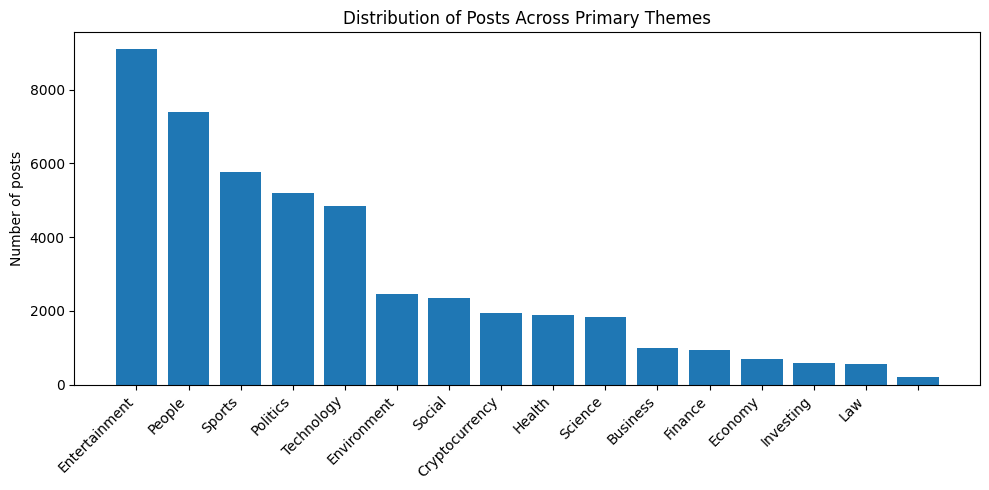

In [22]:
# ============================================================
# TOPIC OVERVIEW: COUNT + PRIMARY THEME DISTRIBUTION
# ============================================================
import polars as pl
import matplotlib.pyplot as plt

# 1. Filter out noise topic (-1)
df_topics_only = df_full_analyzed.filter(pl.col("topic_id") != -1)

# 2. How many distinct topics were produced?
num_topics = df_topics_only["topic_id"].n_unique()
print(f"✅ Total number of non-noise topics: {num_topics}")

# 3. Topic-level table: topic_id, Primary_Theme, Count of posts
topic_theme_table = (
    df_topics_only
    .group_by(["topic_id", "primary_theme"])
    .agg(pl.len().alias("Count"))
    .sort("Count", descending=True)
)

print("\n=== Topic-wise Primary Theme Distribution ===")
print(topic_theme_table)

# 4. Aggregated primary theme distribution (for visualization)
theme_dist = (
    topic_theme_table
    .group_by("primary_theme")
    .agg(pl.col("Count").sum().alias("Total_Posts"))
    .sort("Total_Posts", descending=True)
)

print("\n=== Primary Theme Distribution (Aggregated) ===")
print(theme_dist)

# 5. Bar chart: posts per primary_theme
theme_pdf = theme_dist.to_pandas()

plt.figure(figsize=(10, 5))
plt.bar(theme_pdf["primary_theme"], theme_pdf["Total_Posts"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of posts")
plt.title("Distribution of Posts Across Primary Themes")
plt.tight_layout()
plt.show()


In [23]:
# ============================================================
# 8. HELPER: SEGMENT POSTS FOR A TOPIC INTO TWO EMOTION VIEWPOINTS
#    (curiosity vs disapproval by default) AND SAVE TO TEXT FILES
# ============================================================

def segment_topic_viewpoints(
    df: pl.DataFrame,
    topic_id: int,
    emotion_a: str = "curiosity",
    emotion_b: str = "disapproval",
    drive_path: str = DRIVE_PATH,
):
    """
    For a given topic_id, extract posts where main_emotion == emotion_a or emotion_b,
    concatenate them into two large text blobs, and save to Drive.
    """
    df_topic = df.filter(pl.col("topic_id") == topic_id)

    if df_topic.height == 0:
        raise ValueError(f"No rows found for topic_id = {topic_id}")

    file_a = f"topic_{topic_id}_viewpoint_{emotion_a}_text.txt"
    file_b = f"topic_{topic_id}_viewpoint_{emotion_b}_text.txt"

    # Segment A
    seg_a_df = df_topic.filter(pl.col("main_emotion") == emotion_a)
    text_segment_a = (
        seg_a_df["original_text"]
        .str.concat("\n\n")
        .item()
        if seg_a_df.height > 0
        else ""
    )

    # Segment B
    seg_b_df = df_topic.filter(pl.col("main_emotion") == emotion_b)
    text_segment_b = (
        seg_b_df["original_text"]
        .str.concat("\n\n")
        .item()
        if seg_b_df.height > 0
        else ""
    )

    # Save both segments
    path_a = os.path.join(drive_path, file_a)
    path_b = os.path.join(drive_path, file_b)

    with open(path_a, "w", encoding="utf-8") as f:
        f.write(text_segment_a)
    with open(path_b, "w", encoding="utf-8") as f:
        f.write(text_segment_b)

    print(f"✅ Saved {emotion_a} segment for Topic {topic_id} -> {path_a}")
    print(f"✅ Saved {emotion_b} segment for Topic {topic_id} -> {path_b}")

    return file_a, file_b


In [30]:
# ============================================================
# 9. HELPER: SUMMARIZE VIEWPOINT FILES WITH BART
# ============================================================

print("▶ Loading BART summarization model (facebook/bart-large-cnn)...")
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def generate_viewpoint_summary(
    file_name: str,
    emotion_label: str,
    drive_path: str = DRIVE_PATH,
    max_chunk_chars: int = 2500,
    max_length: int = 120,
    min_length: int = 40,
) -> str:
    """
    Robust summarizer:
      - Reads text from file
      - Splits into manageable character chunks
      - Summarizes each chunk with truncation
      - Summarizes the combined partial summaries again (2-pass)
    """
    import os

    full_path = os.path.join(drive_path, file_name)

    if (not os.path.exists(full_path)) or os.path.getsize(full_path) == 0:
        return f"Not enough {emotion_label} posts found in the file."

    with open(full_path, "r", encoding="utf-8") as f:
        text_content = f.read().strip()

    if not text_content:
        return f"Not enough {emotion_label} posts found in the file."

    # ---- 1. Split into chunks of up to max_chunk_chars ----
    paragraphs = text_content.split("\n\n")
    chunks = []
    current = ""

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        if len(current) + len(para) + 2 <= max_chunk_chars:
            if current:
                current += "\n\n" + para
            else:
                current = para
        else:
            chunks.append(current)
            current = para

    if current:
        chunks.append(current)

    if not chunks:
        return f"Not enough {emotion_label} posts found in the file."

    # ---- 2. Summarize each chunk separately ----
    partial_summaries = []
    for i, ch in enumerate(chunks):
        try:
            result = summarizer(
                ch,
                max_length=max_length,
                min_length=min_length,
                do_sample=False,
                truncation=True,
            )
            partial_summaries.append(result[0]["summary_text"])
        except Exception as e:
            print(f"⚠️ Error summarizing chunk {i}: {e}")
            # Skip problematic chunk
            continue

    if not partial_summaries:
        return f"Could not generate a summary for the {emotion_label} viewpoint."

    # ---- 3. Second pass: summarize the concatenated partial summaries ----
    combined = "\n\n".join(partial_summaries)

    try:
        final = summarizer(
            combined,
            max_length=max_length,
            min_length=min_length,
            do_sample=False,
            truncation=True,
        )
        return final[0]["summary_text"]
    except Exception as e:
        print(f"⚠️ Error in second-pass summarization: {e}")
        # Fall back to concatenated partial summaries
        return combined


▶ Loading BART summarization model (facebook/bart-large-cnn)...


Device set to use cpu


In [33]:
# ============================================================
# 10. FULL VIEWPOINT DISSECTION FOR A GIVEN TOPIC
#      - chooses curiosity vs disapproval
#      - prints a clean final report
# ============================================================

# --- Set the topic to analyze ---
TOPIC_ID_TO_ANALYZE = 1     # e.g., Topic 3
EMOTION_A = "curiosity"
EMOTION_B = "disapproval"

try:
    topic_name = (
        topic_summary_df
        .filter(pl.col("topic_id") == TOPIC_ID_TO_ANALYZE)
        .select("Primary_Theme")
        .to_series()
        .item()
    )
except Exception:
    topic_name = f"Topic {TOPIC_ID_TO_ANALYZE}"

# --- 1. Segment & save text blobs for each viewpoint ---
file_a, file_b = segment_topic_viewpoints(
    df_full_analyzed,
    topic_id=TOPIC_ID_TO_ANALYZE,
    emotion_a=EMOTION_A,
    emotion_b=EMOTION_B,
    drive_path=DRIVE_PATH,
)

# --- 2. Summarize each viewpoint ---
print(f"\n▶ Generating summary for {EMOTION_A.upper()} viewpoint...")
summary_a = generate_viewpoint_summary(file_a, EMOTION_A)

print(f"\n▶ Generating summary for {EMOTION_B.upper()} viewpoint...")
summary_b = generate_viewpoint_summary(file_b, EMOTION_B)

# --- 3. Final dissected viewpoint report ---
final_report = f"""
--- DISSECTED TOPIC VIEWPOINT SUMMARY ---
Topic {TOPIC_ID_TO_ANALYZE}: {topic_name}

### A. The {EMOTION_A.capitalize()} Viewpoint (Inquiry / Information-Seeking)
{summary_a}

### B. The {EMOTION_B.capitalize()} Viewpoint (Criticism / Judgment)
{summary_b}

--- END VIEWPOINT ANALYSIS ---
"""

print(final_report)


✅ Saved curiosity segment for Topic 1 -> /content/drive/My Drive/DS_Project/topic_1_viewpoint_curiosity_text.txt
✅ Saved disapproval segment for Topic 1 -> /content/drive/My Drive/DS_Project/topic_1_viewpoint_disapproval_text.txt

▶ Generating summary for CURIOSITY viewpoint...


Your max_length is set to 120, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)



▶ Generating summary for DISAPPROVAL viewpoint...


Your max_length is set to 120, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)



--- DISSECTED TOPIC VIEWPOINT SUMMARY ---
Topic 1: shape: (1,)
Series: '' [str]
[
	"Politics"
]

### A. The Curiosity Viewpoint (Inquiry / Information-Seeking)
Canada has objectively been a disaster, but something I wonder about is why we never heard these stories about Oregon? Is the law fundamentally different, or is it also a shitshow and it just gets covered up, or what? Why does the Canadian gov't hide UKR-Nazism? What is wrong with you people?

### B. The Disapproval Viewpoint (Criticism / Judgment)
Canadian writer says he doesn't trust a word of what PM Justin Trudeau has said. Canada and the USA are among each other's mutual strongest allies, regardless of fed govt administrations. No sane person believes the CBC.

--- END VIEWPOINT ANALYSIS ---

